In [1]:
%run setup.py

In [2]:
rv_jd, rv_rv, rv_err = np.loadtxt('../../data/kic6780873_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd += 2400000
rv_jd -= 2454833

In [3]:
# t, y = lc.time, lc.flux
time, mag = np.loadtxt('../../data/kic6780873_lc.txt', usecols=(0,1)).T
time += 2400000
time -= 2454833
time, mag = time, mag*1e3

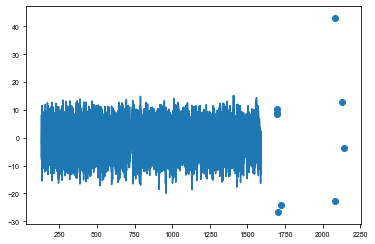

In [4]:
plt.plot(time, mag)
plt.scatter(rv_jd, rv_rv)

In [5]:
freq = np.array([14.18764198, 13.43633836])


In [24]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

rv = True

with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=0, upper=12)("P", mu=9.159, sd=1,
                                     shape=1, testval=9.159)

    # Wide log-normal prior for semi-amplitude
    logasini = pm.Bound(pm.Normal, lower=0, upper=25)("logasini", mu=np.log(18), sd=5,
                                        shape=1, testval=np.log(18))
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(mag)), sd=10, testval=0.)
    asini = pm.Deterministic('asini', tt.exp(logasini))
    logs = pm.Normal("logs", mu=np.log(np.median(rv_err)), sd=5.0)
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.27)
    omega = xo.distributions.Angle("omega", shape=1)
    phi = xo.distributions.Angle('phi', testval=0.)
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    
    # LIGHTCURVE
    M = 2. * np.pi * time / P - phi
    f = get_true_anomaly(M, ecc + tt.zeros_like(M))
    psi = -((1 - tt.square(ecc)) * tt.sin(f+omega) / (1 + ecc*tt.cos(f)))
    tau = (asini / 86400.) * psi[:, None]
    arg = 2. * np.pi * nu * (time[:, None] - tau)
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, mag))
    lc_model = tt.dot(D, w)
    full_lc = lc_model
    
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.01))("logw0", mu=np.log(2*np.pi/10), sd=100,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    gp_l = gp.log_likelihood(mag - full_lc)
    # Weight likelihood equally with RV data
    pm.Potential("obs", gp_l#/ (len(time) / len(rv_jd))
                )
    
    if rv:
        
        gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=0.)
        logs_rv = pm.Normal('logs_rv', mu=np.log(np.std(rv_rv)), sd=10, testval=np.log(np.std(rv_rv)))

        M_RV = 2. * np.pi * rv_jd / P - phi
        # True anom
        f_RV = get_true_anomaly(M_RV, ecc + tt.zeros_like(M_RV))
        vrad = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f_RV + omega) + ecc*tt.cos(omega))
        vrad *= 299792.458  # c in km/s
        vrad += gammav # Systemic velocity

        err = tt.sqrt(2*rv_err**2 + tt.exp(2*logs_rv))
        pm.Normal("obs_rv", mu=vrad, sd=err, observed=rv_rv)
        
t = np.linspace(rv_jd.min()-5, rv_jd.max()+5, 1000)
with model:
    M2 = 2. * np.pi * t / P - phi
    f2 = get_true_anomaly(M2, ecc + tt.zeros_like(M2))
    vrad2 = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f2 + omega) + ecc*tt.cos(omega))
    vrad2 *= 299792.458  # c in km/s|
    vrad2 += gammav # Systemic velocity
#     pm.Deterministic("vrad_pred", vrad2)

In [25]:
with model:
    trace = pm.load_trace('KIC 6780873/join_trace_X')

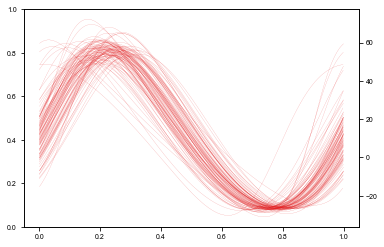

In [37]:
fig, ax = plt.subplots()
ax2 = plt.twinx()
with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=100):
#         taumod = xo.eval_in_model(tau, point=samp)*86400
#         #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
#         ttime = (time) % samp['P'] / samp['P']
#         #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
#         sort = np.argsort(ttime)
#         ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.1, alpha=1, rasterized=True)
        
        
        rvmod = xo.eval_in_model(vrad2, samp)
#         ttime = t % samp['P'] / samp['P']
        ttime = t + samp['phi'] * samp['P'] / (2*np.pi)#xo.eval_in_model(phi * period / (2*np.pi), samp)
        fold = ttime % samp['P'] / samp['P']
        sort = np.argsort(fold)
        ax2.plot(fold[sort], rvmod[sort], linewidth=0.1, c=red)

In [8]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-2.088642,1.349544e-02,2.113497e-04,-2.114256,-2.062245,4825.693707,1.000023
logs,-1.724688,4.966083e+00,7.132436e-02,-11.085317,8.291491,4744.780382,0.999577
lognu__0,2.652371,2.485273e-08,4.338329e-10,2.652371,2.652371,3963.872346,1.000782
lognu__1,2.597963,5.169964e-08,8.663369e-10,2.597963,2.597963,3890.477307,1.000538
logpower,10.883314,8.421268e-03,1.214386e-04,10.866922,10.899663,4394.908351,1.000678
logs_rv,0.092123,4.665909e-01,1.313891e-02,-0.718648,1.023430,934.044117,1.001348
P__0,9.159153,8.300001e-04,1.173631e-05,9.157563,9.160761,3567.599896,0.999540
logasini__0,2.857998,4.127166e-02,9.113102e-04,2.770108,2.936679,1483.864942,1.001301
asini__0,17.441530,7.265528e-01,1.593475e-02,15.960357,18.853124,1512.995524,1.001206
ecc__0,0.104384,4.749688e-02,1.167331e-03,0.018239,0.189297,1227.041783,1.001547


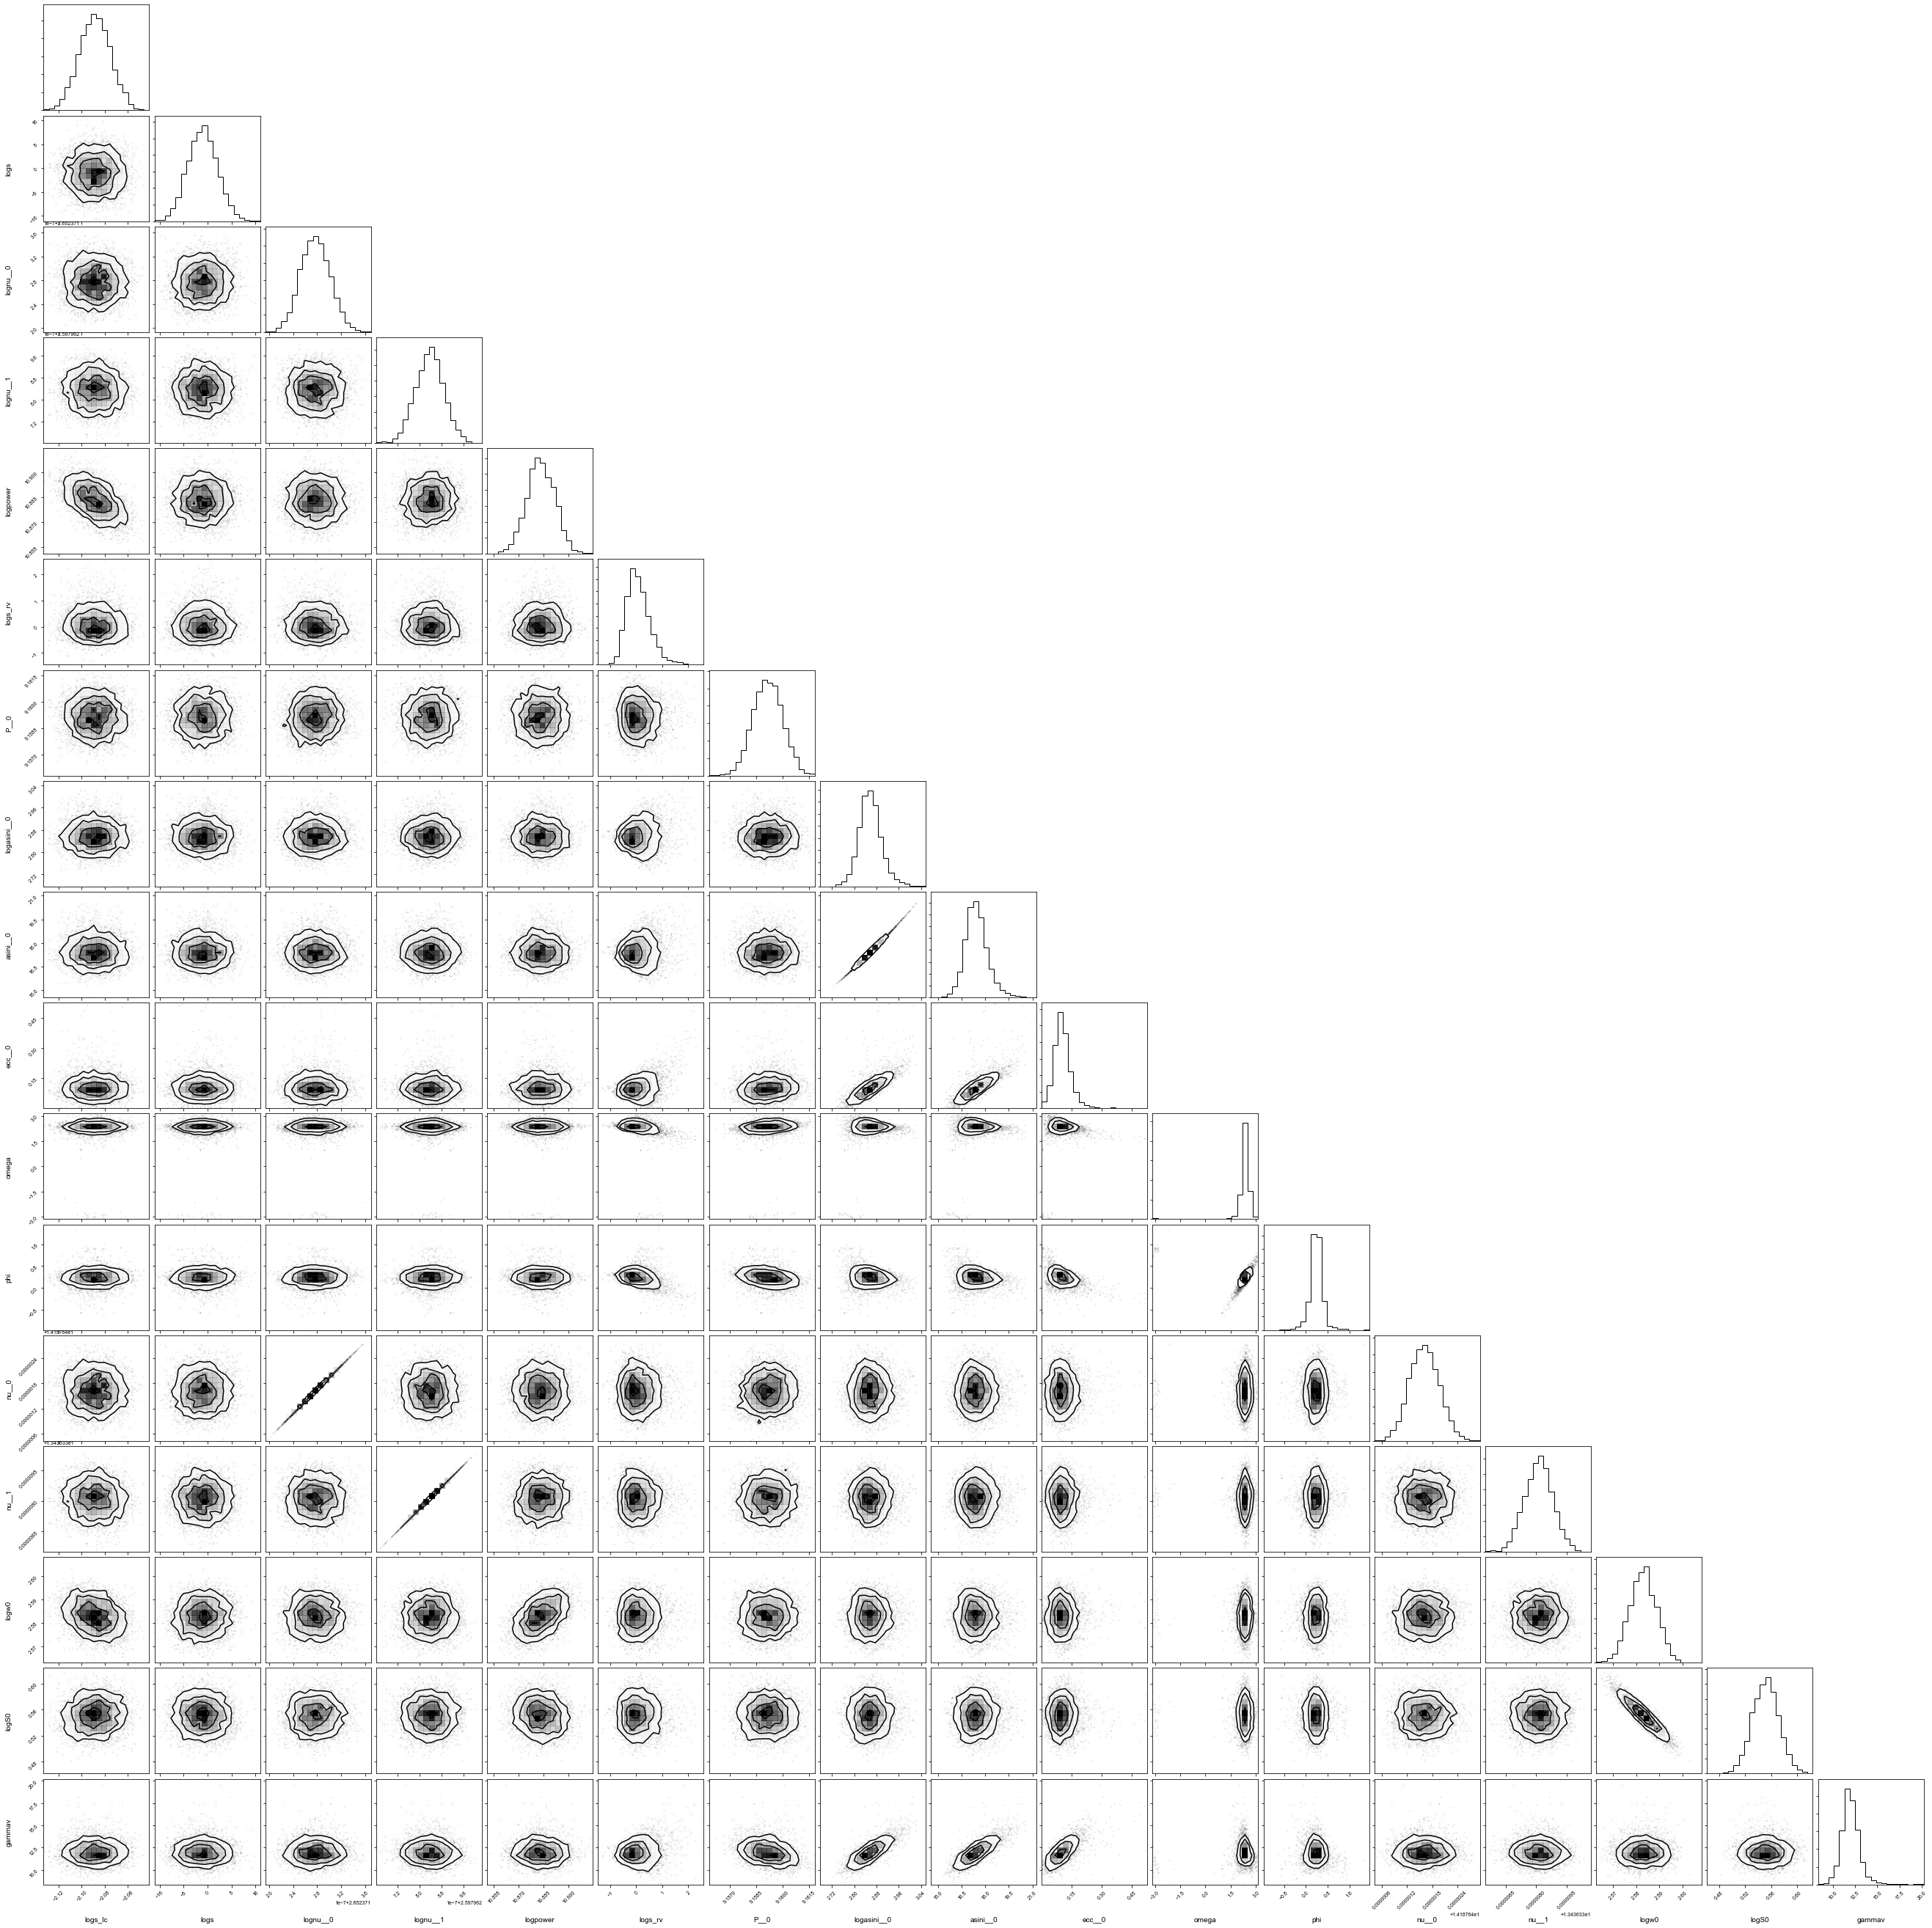

In [9]:
import corner

corner.corner(pm.trace_to_dataframe(trace));

In [38]:
varnames=['P', 'phi', 'ecc', 'asini', 'omega']
rounding = 3
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(f"{varname}: {med:.3f}+{(upper-med):.3f}-{(med-lower):.3f}")
#     print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

P: 9.159+0.001-0.001
phi: 0.381+0.185-0.187
ecc: 0.099+0.040-0.033
asini: 17.392+0.709-0.623
omega: 2.365+0.171-0.199


In [40]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['P', 'asini'])
mfs = mass_function(samples['P__0'].values * u.day, samples['asini__0'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.067  +  0.009  -  0.007


In [11]:
with model:
    if rv:
#         map_soln = xo.optimize(start=model.test_point)
        map_soln = xo.optimize(start=model.test_point, vars=[gammav])
        map_soln = xo.optimize(start=map_soln, vars=[phi])
    
    all_but = [v for v in model.vars if v.name not in ["P_interval__"]]
    map_params = xo.optimize(start=None, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[ecc, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params,
                             vars=all_but
                            )

    map_params = xo.optimize(start=map_params, vars=[P])
    map_params = xo.optimize(start=map_params, 
                             vars=all_but
                            )
    

optimizing logp for variables: [gammav]
5it [00:00, 18.95it/s, logp=-3.232151e+05]
message: Optimization terminated successfully.
logp: -323215.0540864211 -> -323215.05385737336
optimizing logp for variables: [phi]
74it [00:03, 22.92it/s, logp=-3.231911e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -323215.05385737336 -> -323191.0856525172
optimizing logp for variables: [logs_lc]
10it [00:00, 22.32it/s, logp=-1.771360e+05]
message: Optimization terminated successfully.
logp: -323215.0540864211 -> -177135.9570863404
optimizing logp for variables: [logw0, logpower]
75it [00:04, 16.48it/s, logp=-1.581635e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -177135.9570863404 -> -158163.5111935708
optimizing logp for variables: [omega, ecc]
21it [00:01, 19.45it/s, logp=-1.581392e+05]
message: Optimization terminated successfully.
logp: -158163.5111935708 -> -158139.21522978405
optimizing logp for variables: [phi]
55it [00:02,

In [12]:
map_params


{'P_interval__': array([1.1706146]),
 'logasini_interval__': array([-2.01703334]),
 'logs_lc': array(-2.08834148),
 'logs': array(-1.71479843),
 'ecc_logodds__': array([0.08637011]),
 'omega_angle__': array([4.45995647, 0.32983153]),
 'phi_angle__': array([-1.93285247,  4.03287481]),
 'lognu': array([2.65237128, 2.59796284]),
 'logw0_interval__': array(0.32635175),
 'logpower': array(10.88276051),
 'gammav_interval__': array(1.6116148),
 'logs_rv': array(2.27000842),
 'P': array([9.15907308]),
 'logasini': array([2.93565245]),
 'asini': array([18.83378733]),
 'ecc': array([0.52157911]),
 'omega': array(1.49697673),
 'phi': array(-0.44692984),
 'nu': array([14.18764161, 13.43633811]),
 'logw0': array(2.58273053),
 'logS0': array(0.55183838),
 'gammav': array(3.33635459)}

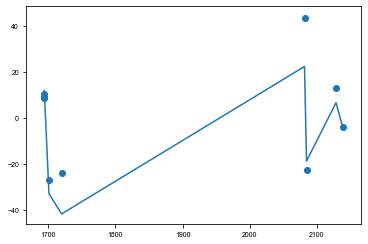

In [13]:
with model:
    plt.plot(rv_jd, xo.eval_in_model(vrad, map_params))
    plt.scatter(rv_jd, rv_rv)

In [12]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.9), start=map_params
    )

Only 5 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs_rv, gammav, logpower, logw0, lognu, phi, omega, ecc, logs, logs_lc, logasini, P]
Sampling 2 chains: 100%|██████████| 20/20 [00:01<00:00, 15.22draws/s]
/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.


In [16]:
pm.save_trace(trace,'KIC 6780873/join_trace_X')

'KIC 6780873/join_trace'